In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm

import seaborn as sns

In [3]:
!sbt "run-main ZeroIntelligenceApp"

[info] Loading global plugins from /Users/drpugh/.sbt/0.13/plugins
[info] Loading project definition from /Users/drpugh/Research/scalabm/models-library/gode-sunder/project
[info] Set current project to gode-sunder-model (in build file:/Users/drpugh/Research/scalabm/models-library/gode-sunder/)
[info] Running ZeroIntelligenceApp 
[info] -XX:InitialHeapSize=3226678064 -XX:MaxHeapSize=6442450944 -XX:MaxNewSize=3221225472 -XX:NewSize=3221225472 -XX:+PrintCommandLineFlags -XX:-UseBiasedLocking -XX:+UseCompressedClassPointers -XX:+UseCompressedOops -XX:+UseCondCardMark -XX:+UseNUMA -XX:+UseParallelGC 
[info] [INFO] [02/24/2016 22:11:59.425] [gode-sunder-model-akka.actor.default-dispatcher-24] [akka://gode-sunder-model/user/$StH] Message [markets.participants.LiquiditySupplier$SubmitLimitBidOrder$] from Actor[akka://gode-sunder-model/user/$StH#374970304] to Actor[akka://gode-sunder-model/user/$StH#374970304] was not delivered. [1] dead letters encountered. This logging can be turned off or ad

## Importing the raw JSON data

In [4]:
tmp_df = pd.read_json('./data/zero-intelligence/Gpi2.json', orient='records')
zi_data = tmp_df.iloc[::-1].set_index('timestamp')

In [5]:
zi_data.head()

,askPrice,bidPrice,price,quantity
timestamp,,,,
2016-02-24 22:10:30.458,50,150,100,1
2016-02-24 22:10:30.565,3,85,3,1
2016-02-24 22:10:30.610,4,41,4,1
2016-02-24 22:10:30.615,17,155,17,1
2016-02-24 22:10:30.615,2,199,2,1


In [6]:
zi_data.tail()

,askPrice,bidPrice,price,quantity
timestamp,,,,
2016-02-24 22:12:00.947,38,109,109,1
2016-02-24 22:12:00.947,143,190,143,1
2016-02-24 22:12:00.947,143,177,143,1
2016-02-24 22:12:00.947,46,55,55,1
2016-02-24 22:12:00.947,110,174,110,1


In [7]:
zi_data.describe()

,askPrice,bidPrice,price,quantity
count,233571.000000,233571.000000,233571.000000,233571
mean,77.969881,121.806890,99.801692,1
std,44.915830,45.091464,30.992005,0
min,1.000000,27.000000,2.000000,1
25%,39.000000,83.000000,74.000000,1
50%,78.000000,122.000000,100.000000,1
75%,117.000000,161.000000,125.000000,1
max,161.000000,199.000000,161.000000,1


### Compute the bid-ask spread...

    spread = bidPrice - askPice

In [8]:
zi_data['spread'] = zi_data.bidPrice - zi_data.askPrice

In [9]:
zi_data.spread.describe()

count    233571.000000
mean         43.837009
std          29.933827
min           1.000000
25%          20.000000
50%          39.000000
75%          62.000000
max         197.000000
Name: spread, dtype: float64

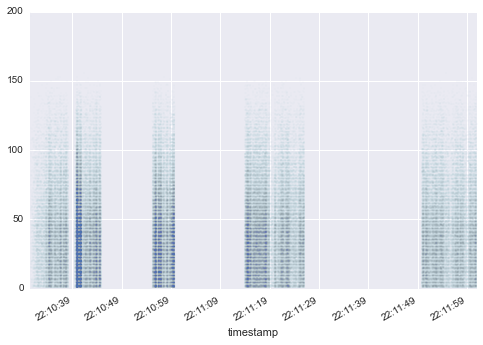

In [10]:
zi_data.spread.plot(linestyle='none', marker='o', markersize=1, alpha=0.05)
plt.show()

<h2> Compute raw returns </h2>

$$ r_{t+k} = \frac{p_{t+k} - p_{t}}{p_{t}} = \frac{\Delta p_{t+k}}{p_{t}}$$ 

Note that raw returns are bounded below! Bounds on price (at least in these simulations!) are $1 \le p_t \le 200$. Therefore lower bound on raw returns is...

$$ \underline{r} = \frac{1 - 200}{200} \approx -1. $$

Similarly, then upper bound on raw returns is...

$$ \underline{r} = \frac{200 - 1}{1} = 199. $$


In [11]:
zi_data['raw_returns'] = zi_data.price.pct_change(periods=1)

In [12]:
zi_data.raw_returns.describe()

count    233570.000000
mean          0.106827
std           0.525518
min          -0.970000
25%          -0.240195
50%           0.000000
75%           0.311321
max          12.500000
Name: raw_returns, dtype: float64

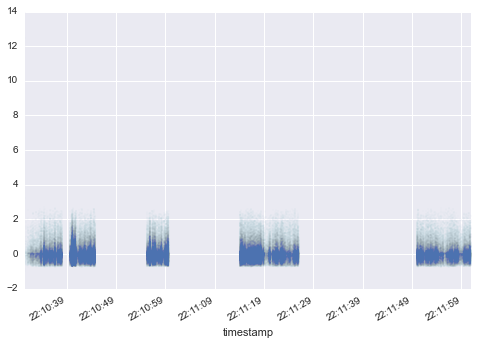

In [13]:
zi_data.raw_returns.plot(linestyle='none', marker='o', markersize=1, alpha=0.05)
plt.show()

## Compute logarithmic returns

Starting from raw returns, $r_{t+k}$ we see that...

$$ 1 + r_{t+k} = 1 + \frac{p_{t+k} - p_t}{p_t} = \frac{p_{t+k}}{p_t} $$

...taking logs yields...

$$ \ln \big(1 + r_{t+k}\big) = \ln p_{t+k} - \ln p_t = \Delta \ln p_{t+k} $$

...since $\ln \big(1 + r_{t+k}\big) \approx r_{t+k}$ for $r << 1$ we should expect that raw and logarithmic return formulas should yields similar results for "small" returns.


In [14]:
zi_data['log_returns'] = np.log(1 + zi_data.raw_returns)

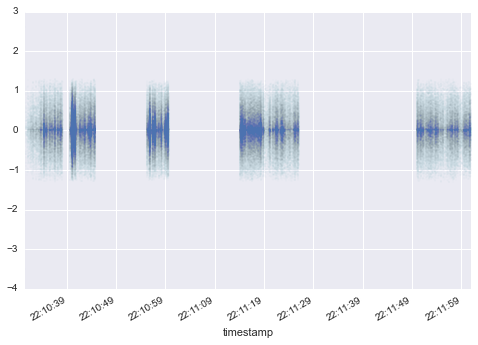

In [15]:
zi_data.log_returns.plot(linestyle='none', marker='o', markersize=1, alpha=0.05)
plt.show()

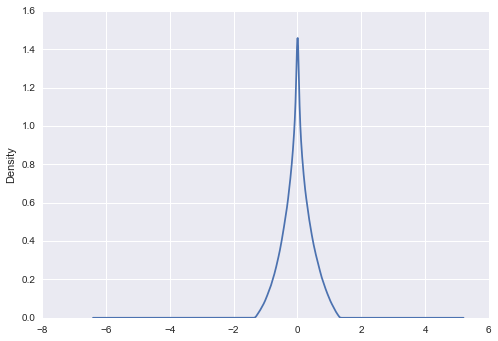

In [49]:
zi_data.log_returns.dropna().plot(kind='kde')
plt.show()

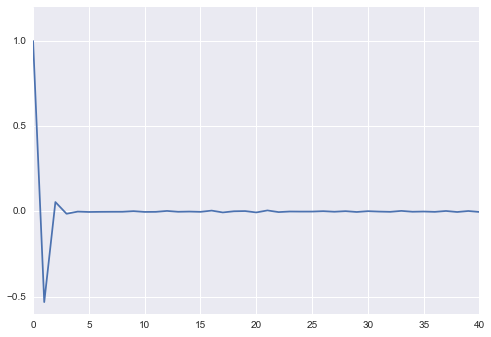

In [20]:
plt.plot(sm.tsa.acf(zi_data.log_returns.dropna(), fft=True))
plt.show()

<h3> Price impact </h3>

In [50]:
zi_data['mid_price'] = 0.5 * (zi_data.askPrice + zi_data.bidPrice)

How to best measure effective size? Particularly of ask orders!

In [51]:
zi_data['effective_size'] = zi_data.quantity

incoming_ask_orders = zi_data.bidPrice == zi_data.price
zi_data.loc[incoming_ask_orders, 'effective_size'] *= -zi_data.loc[incoming_ask_orders, 'askPrice']

incoming_bid_orders = zi_data.askPrice == zi_data.price
zi_data.loc[incoming_bid_orders, 'effective_size'] *= zi_data.loc[incoming_bid_orders, 'bidPrice']

Compute the measure of price impact: $\Delta \ln$ `mid_price`...

In [52]:
zi_data['price_impact'] = np.log(zi_data.mid_price).diff()

In [53]:
zi_data[incoming_ask_orders].head()

,askPrice,bidPrice,price,quantity,spread,raw_returns,log_returns,mid_price,effective_size,price_impact
timestamp,,,,,,,,,,
2016-02-24 14:15:10.291,3,30,30,1,27,9.000000,2.302585,16.5,-3,-1.221991
2016-02-24 14:15:10.292,5,22,22,1,17,-0.747126,-1.374866,13.5,-5,-2.079442
2016-02-24 14:15:10.292,47,91,91,1,44,-0.107843,-0.114113,69.0,-47,-0.553385
2016-02-24 14:15:10.293,17,102,102,1,85,-0.019231,-0.019418,59.5,-17,-0.834005
2016-02-24 14:15:10.294,3,104,104,1,101,-0.187500,-0.207639,53.5,-3,-0.914420


/Users/drpugh/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


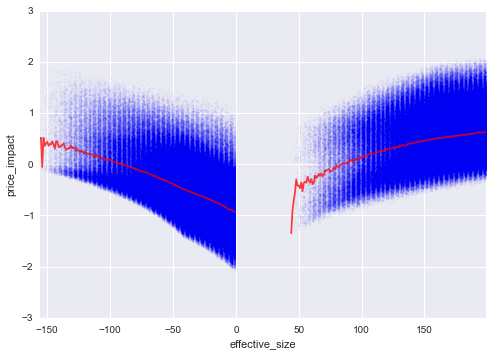

In [54]:
# incoming bid orders
fig, ax = plt.subplots(1, 1)
grouped_data = zi_data.groupby("effective_size")
grouped_data.price_impact.mean().plot(color='r', alpha=0.75, ax=ax)
ax.scatter(zi_data.effective_size, zi_data.price_impact, edgecolor='b', s=1, alpha=0.05)
ax.set_ylabel("price_impact")
plt.show()

## Cumulative distributions

In [55]:
ecdfs = {} 
for column_name in ['raw_returns', 'log_returns']:
    ecdfs[column_name] = sm.distributions.ECDF(zi_data[column_name].abs())

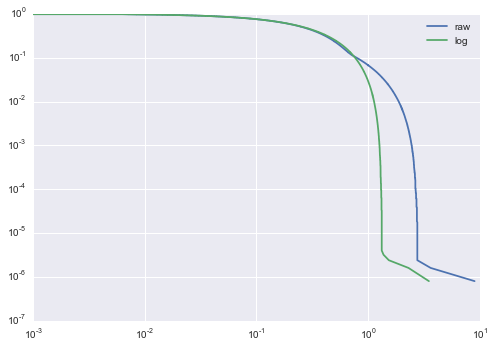

In [56]:
plt.plot(ecdfs['raw_returns'].x, 1 - ecdfs['raw_returns'].y, label='raw')
plt.plot(ecdfs['log_returns'].x, 1 - ecdfs['log_returns'].y, label='log')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

<h3> Zero Intelligence Constrained </h3>

In [84]:
!sbt "run-main ZeroIntelligenceConstrainedApp"

[info] Loading global plugins from /Users/drpugh/.sbt/0.13/plugins
[info] Loading project definition from /Users/drpugh/Research/scalabm/models-library/gode-sunder/project
[info] Set current project to gode-sunder-model (in build file:/Users/drpugh/Research/scalabm/models-library/gode-sunder/)
[info] Running ZeroIntelligenceConstrainedApp 
[info] -XX:InitialHeapSize=3226678064 -XX:MaxHeapSize=6442450944 -XX:MaxNewSize=3221225472 -XX:NewSize=3221225472 -XX:+PrintCommandLineFlags -XX:-UseBiasedLocking -XX:+UseCompressedClassPointers -XX:+UseCompressedOops -XX:+UseCondCardMark -XX:+UseNUMA -XX:+UseParallelGC 
[info] [INFO] [02/24/2016 17:40:13.979] [gode-sunder-model-akka.actor.default-dispatcher-25] [akka://gode-sunder-model/user/$5Ob] Message [markets.participants.LiquiditySupplier$SubmitLimitBidOrder$] from Actor[akka://gode-sunder-model/user/$5Ob#-1340548102] to Actor[akka://gode-sunder-model/user/$5Ob#-1340548102] was not delivered. [1] dead letters encountered. This logging can be t

In [85]:
tmp_df = pd.read_json('./data/zero-intelligence-constrained/Gpi2.json', orient='records')
zic_data = tmp_df.iloc[::-1].set_index('timestamp')

In [89]:
zic_data.describe()

,askPrice,bidPrice,price,quantity,spread,raw_returns,log_returns
count,241592.000000,241592.000000,241592.000000,241592,241592.000000,241591.000000,2.415910e+05
mean,83.918677,113.921107,98.966886,1,30.002430,0.013624,6.498742e-07
std,29.059987,29.041357,15.039957,0,21.923768,0.168537,1.643470e-01
min,0.000000,71.000000,71.000000,1,1.000000,-0.428571,-5.596158e-01
25%,64.000000,90.000000,87.000000,1,12.000000,-0.085106,-8.894749e-02
50%,88.000000,109.000000,99.000000,1,26.000000,0.000000,0.000000e+00
75%,108.000000,134.000000,111.000000,1,44.000000,0.092105,8.810727e-02
max,148.000000,198.000000,149.000000,1,122.000000,0.907895,6.460004e-01


In [87]:
zic_data['spread'] = zic_data.bidPrice - zic_data.askPrice
zic_data['raw_returns'] = zic_data.price.pct_change(periods=1)
zic_data['log_returns'] = np.log(1 + zic_data.raw_returns)

In [81]:
zi_data.spread.describe()

count    1250457.000000
mean          43.858537
std           29.947651
min            1.000000
25%           20.000000
50%           39.000000
75%           63.000000
max          156.000000
Name: spread, dtype: float64

In [88]:
zi_data.spread.describe()

count    1250457.000000
mean          43.858537
std           29.947651
min            1.000000
25%           20.000000
50%           39.000000
75%           63.000000
max          156.000000
Name: spread, dtype: float64

In [72]:
zic_data.spread.describe()

count    211916.000000
mean         30.464156
std          22.163429
min           1.000000
25%          12.000000
50%          26.000000
75%          45.000000
max         121.000000
Name: spread, dtype: float64

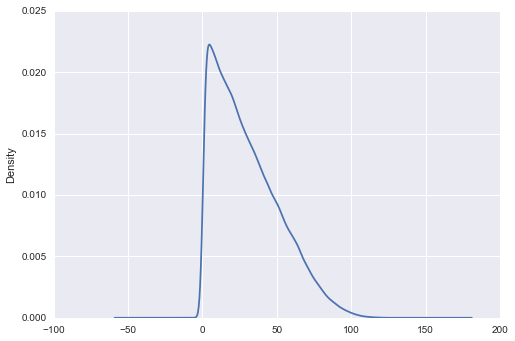

In [83]:
zic_data.spread.dropna().plot(kind='kde')
plt.show()

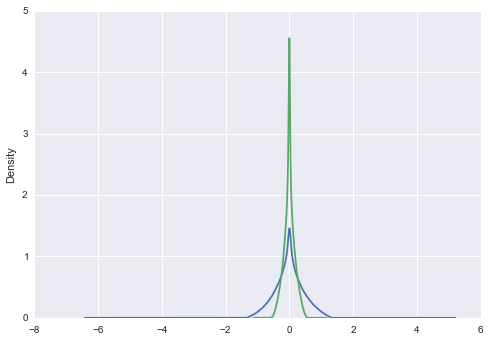

In [70]:
zi_data.log_returns.dropna().plot(kind='kde')
zic_data.log_returns.dropna().plot(kind='kde')
plt.show()

In [61]:
zi_data.log_returns.describe()

count    1.250456e+06
mean    -5.704718e-07
std      4.398553e-01
min     -3.506558e+00
25%     -2.623643e-01
50%      0.000000e+00
75%      2.597533e-01
max      2.302585e+00
Name: log_returns, dtype: float64

In [62]:
zic_data.log_returns.describe()

count    4.121000e+05
mean     4.825306e-07
std      1.780591e-01
min     -5.798185e-01
25%     -1.017827e-01
50%      0.000000e+00
75%      1.013525e-01
max      5.798185e-01
Name: log_returns, dtype: float64

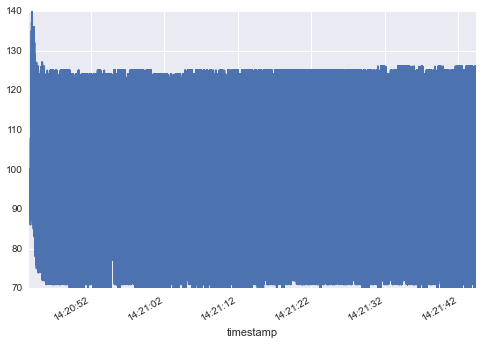

In [64]:
zic_data.price.plot()
plt.show()

In [65]:
zic_data.price.describe()

count    412101.000000
mean         97.785936
std          15.034160
min          70.000000
25%          85.000000
50%          98.000000
75%         110.000000
max         140.000000
Name: price, dtype: float64